Image Classifier Part 2
~ MLP and Deep Convolutional Networks ~
===========================

In [139]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import torch
import torch.nn as nn

# Definirea mediului pe care va rula codul de antrenare
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Running code @ {device}')

import numpy as np

# Plotting library.
from matplotlib import pyplot as plt
import pylab as pl
from IPython import display

import collections
import enum
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler

Running code @ cpu


## Fashion-MNIST

### 1.  MLP pe atributele extrase în etapa 1

#### Descărcare și preparare date

* **Fashion-MNIST** este echivalentul MNIST pentru imagini vestimentare grey

* cuprinde 60k imagini din 10 clase: T-shirt, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot

* train: 60k; test: 10k

* Fiecare imagine are cate 16 atribute extrase folosind algoritmul HOG, PCA si Selection 80%


In [149]:
# Prepare data
import torch
from torch.utils.data import Dataset

# define dimension of the batches to sample from the datasets
BATCH_SIZE_TRAIN = 100  #@param
BATCH_SIZE_TEST = 100  #@param
NO_WORKERS = 0  #@param
SHUFFLE_DATA = True  #@param
NUM_CLASSES = 10  # @param

# General parameters
flag_batch_norm = 'ON'  # @param['ON', 'OFF']
flag_regularize = True     # @param['True', 'False'] {type:"raw"}

In [96]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)  # Convert to PyTorch tensors
        self.targets = torch.tensor(labels, dtype=torch.long)  # Convert to PyTorch tensors

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [151]:
# Load fashion attributes
train_images = np.load('data/fashion/X_train20_scaled.npy')
y_train = np.load('data/fashion/y_train.npy')
test_images = np.load('data/fashion/X_test20_scaled.npy')
y_test = np.load('data/fashion/y_test.npy')

# Normalize
scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)

# Create datasets
train_images = MyDataset(train_images, y_train)
test_images = MyDataset(test_images, y_test)

# Check sizes of tensors
print(f'Size of training images {train_images.data.shape}')
print(f'Size of training labels {len(train_images.targets)}')
print(f'Size of test images {test_images.data.shape}')
print(f'Size of test labels {len(test_images.targets)}')

Size of training images torch.Size([60000, 16])
Size of training labels 60000
Size of test images torch.Size([10000, 16])
Size of test labels 10000


#### Afișare imagini
Implementarea unei „galerii” de imagini pentru vizualizarea setului de date.

In [99]:
MAX_IMAGES = 10

def gallery(images, label, title='Input images'):
    class_dict = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    images = images.reshape(60000, 28, 28)
    images = images.reshape(60000, 28, 28, 1)
    print(images.shape)
    num_frames, h, w, num_channels = images.shape
    num_frames = min(num_frames, MAX_IMAGES)
    ff, axes = plt.subplots(1, num_frames, figsize=(num_frames, 1), subplot_kw={'xticks': [], 
                                                                                'yticks': []})
    for i in range(0, num_frames):
        if num_channels == 3:
            axes[i].imshow(np.squeeze(images[i]))
        else:
            axes[i].imshow(np.squeeze(images[i]), cmap='gray')
        axes[i].set_title(class_dict[label[i]])
        plt.setp(axes[i].get_xticklabels(), visible=False)
        plt.setp(axes[i].get_yticklabels(), visible=False)
    ff.subplots_adjust(wspace=0.1)
    plt.show()

(60000, 784)
(60000, 28, 28, 1)


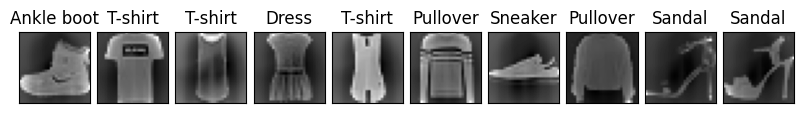

In [100]:
X_train = np.load('data/fashion/X_train.npy')
y_train = np.load('data/fashion/y_train.npy')
print(X_train.shape)
gallery(X_train, y_train)

#### Pregătirea datelor pentru antrenare și testare
* pentru antrenare folosim optimizatori stocastici (e.g. SGD, Adam), asa că trebuie sa putem eșantiona exemple aleatoare din setul de date pentru a forma mini-batch-uri
* pentru testare iterăm în mod secvențial prin setul de date

In [152]:
# create Dataset iterator object using the data previously downloaded
# we shuffle the data and sample repeatedly batches for training
train_loader = torch.utils.data.DataLoader(train_images, batch_size=BATCH_SIZE_TRAIN, 
                                           shuffle=SHUFFLE_DATA, 
                                           num_workers=NO_WORKERS)

# get a training batch of images and labels
(batch_train_images, batch_train_labels) = next(iter(train_loader))

# check that the shape of the training batches is the expected one
print(f'Shape of training images: {batch_train_images.size()}')
print(f'Shape of training labels: {batch_train_labels.size()}')


Shape of training images: torch.Size([100, 16])
Shape of training labels: torch.Size([100])


In [153]:
# we do the same for test dataset
test_loader = torch.utils.data.DataLoader(test_images, batch_size=BATCH_SIZE_TRAIN, 
                                          shuffle=SHUFFLE_DATA, 
                                          num_workers=NO_WORKERS)

def loopy_test_loader(dl):
    data_iter = iter(dl)
    
    while True:
        try:
            yield next(data_iter)
        except StopIteration:
            data_iter = iter(dl)
            yield next(data_iter)

(batch_test_images, batch_test_labels) = next(iter(test_loader))
print(f'Shape of test images: {batch_test_images.size()}')
print(f'Shape of test labels: {batch_test_labels.size()}')


Shape of test images: torch.Size([100, 16])
Shape of test labels: torch.Size([100])


#### Definire MLP

Vom defini un model de tip MLP cu activari ReLU:
  * FC(16, 256) + ReLU
  * FC(256, 256) + ReLU
  * FC(256, 10)

In [105]:
class MLP(nn.Module):
    def __init__(self, num_classes=10, in_size=16):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(in_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

##### Initializarea modelului rețelei și funcții auxiliare pentru inspectarea modelului definit

In [154]:
net = None                       # type: nn.Module
mlp_net = MLP(num_classes=NUM_CLASSES)
    
mlp_net.train()               # Default after init is train
mlp_net = mlp_net.to(device)      # Move network to device

print(list(mlp_net.modules())[0])

# Let us test that we can propagate a batch through the defined networks
select = 2
inputs = batch_train_images.to(device)[:select]
target = batch_train_labels[:select]

output = mlp_net(inputs)
_, predicted = torch.max(output, 1)

print(output)
print(predicted)
print(target)


MLP(
  (fc1): Linear(in_features=16, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)
tensor([[-0.0238,  0.0272, -0.1343,  0.1492,  0.1322,  0.0766, -0.2995,  0.0860,
          0.0006, -0.1934],
        [-0.0538,  0.0248, -0.2521,  0.1188,  0.0120,  0.0124, -0.1245, -0.0892,
         -0.0425, -0.0566]], grad_fn=<AddmmBackward0>)
tensor([3, 3])
tensor([6, 2])


In [113]:
# Get number of parameters in a model by iterating through the model parameters
def get_num_params(model):
    num_params = 0
    for params in model.parameters():
        num_params += params.shape.numel()
        
    return num_params


In [144]:
# Get number of parameters in the model. Verify that we have implemented models correctly
print("Total number of parameters of models")
print(str(mlp_net.__class__), ": ", get_num_params(mlp_net))  

Total number of parameters of models
<class '__main__.MLP'> :  72714


In [115]:
def top_k_accuracy(k, target, output):
    batch_size = target.size(0)
    
    _, pred = output.topk(k, 1, True, True)
    
    pred = pred.t()
    correct = pred.eq(target.to(device).view(1, -1).expand_as(pred))

    correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
    correct_k.mul_(100.0 / batch_size)
    
    return correct_k


##### 4.2 Parametrizarea optimizatorului

In [146]:
lr_init = 0.0001             # initial learning rate
lr_factor = 0.1             # learning rate decay factor
weight_decay_factor = 1e-3  # weight decay factor for L2 weight regularization
lr_schedule_milestones = [50e3, 75e3, 100e3]

In [155]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define optimizer - SGD with momentum and weight_decay for L2 weight regularization
optimizer = torch.optim.SGD(mlp_net.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
# optimizer = torch.optim.Adam(mlp_net.parameters(), lr=lr_init)

if flag_regularize:
    optimizer = torch.optim.SGD(mlp_net.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
    # optimizer = torch.optim.Adam(mlp_net.parameters(), lr=lr_init, weight_decay=weight_decay_factor)
        
# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_schedule_milestones, gamma=lr_factor)

##### Afișarea loss-ului

In [119]:
# Function that takes a list of losses and plots them.
REFRESH_EVERY = 1000

# Funcție pentru afișarea a două grafice: unul pentru eroare și unul pentru acuratețe
def plot_loss_and_accuracy_side_by_side(train_losses, test_losses, train_accuracies, test_accuracies, steps, ct):
    print(f'Step {ct}')
    
    # print all loss and accuracy
    if ct % REFRESH_EVERY == 0:
        display.clear_output(wait=True)
    
    display.display(plt.gcf())
    plt.clf()  # Șterge graficul anterior
    
    # Configurare subploturi
    _, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Graficul pentru pierderi (loss)
    axs[0].plot(steps, train_losses, c='b', label='Train Loss')  # Albastru pentru eroarea de antrenare
    axs[0].plot(steps, test_losses, c='r', label='Test Loss')    # Roșu pentru eroarea de test
    axs[0].set_title('Loss Over Steps')
    axs[0].set_xlabel('Steps')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')
    
    # Graficul pentru acuratețe (accuracy)
    axs[1].plot(steps, train_accuracies, c='b', linestyle='--', label='Train Accuracy')  # Albastru pentru acuratețea de antrenare
    axs[1].plot(steps, test_accuracies, c='r', linestyle='--', label='Test Accuracy')  # Roșu pentru acuratețea de test
    axs[1].set_title('Accuracy Over Steps')
    axs[1].set_xlabel('Steps')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='upper right')
    
    plt.tight_layout()  # Ajustează spațiile dintre subploturi
    plt.show()


##### Model Evaluation

In [38]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pandas as pd

# Funcție pentru calculul metricilor
def evaluate_model(net, loader, device):
    net.eval()  # Setăm modelul în modul de evaluare
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            preds = torch.argmax(outputs, axis=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculăm metricile
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)
    
    return precision, recall, f1, accuracy

# Date pentru diferite experimente
results = []

#### Parametrizarea iterațiilor de antrenare, raportare și testare

In [92]:
# Define number of training iterations and reporting intervals
TRAIN_ITERS = 100e3  # @param
REPORT_TRAIN_EVERY = 100  # @param
PLOT_EVERY = 100  # @param
REPORT_TEST_EVERY = 100  # @param
TEST_ITERS = 100  # @param

#### Antrenarea modelului si Evaluare

In [126]:
def train_mlp(train_dataset_size, batch_size_train, train_loader, test_loader, net, lr_scheduler, optimizer):
    epochs = int(TRAIN_ITERS / (train_dataset_size / batch_size_train))

    train_iter = 0
    train_losses = []
    train_accuracy = []
    test_losses = []
    test_accuracy = []
    steps = []

    # simulate an inifinte test data provider by looping over the test data
    test_data_provider = loopy_test_loader(test_loader)

    # set model in train mode
    net.train()

    running_loss = 0.0
    running_acc = 0.0
    ct = 0

    for epoch in range(int(epochs)):  # loop over the dataset multiple times
        
        for i, data in enumerate(train_loader, 0):
            # set the learning rate and decay according to iteration schedule
            lr_scheduler.step()
            
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            running_acc += top_k_accuracy(1, labels, outputs)
            
            if train_iter % REPORT_TRAIN_EVERY == REPORT_TRAIN_EVERY - 1:    # print every REPORT_TRAIN_EVERY mini-batch iterations
                train_loss = running_loss / REPORT_TRAIN_EVERY
                train_acc = running_acc / REPORT_TRAIN_EVERY
                
                print('[%d, %5d, %6d] LR: %.5f' % (epoch + 1, i + 1, train_iter, lr_scheduler.get_lr()[-1]))
                print('[%d, %5d] loss: %.5f, acc: %.5f' %
                    (epoch + 1, i + 1, train_loss, train_acc))
                
                train_losses.append(train_loss)
                train_accuracy.append(train_acc.item())
                steps.append(train_iter)
                
                running_loss = 0
                train_loss = 0
                train_acc = 0
                running_acc = 0
                
            if train_iter % PLOT_EVERY == 0:
                # plot_losses(losses, acc, steps, train_iter)
                plot_loss_and_accuracy_side_by_side(train_losses, test_losses, train_accuracy, test_accuracy, steps, train_iter)
                
            train_iter += 1
        
            if train_iter % REPORT_TEST_EVERY == 0:
                # set model in test mode
                net.eval()
                
                with torch.no_grad():
                    # evaluate over at most TEST_ITER sub samples from the test_loader
                    test_iter = 0
                    test_loss = 0
                    correct = 0
                    
                    while test_iter < TEST_ITERS:
                    # for j, test_data in enumerate(test_loader, start=test_ct):
                        test_data = next(test_data_provider)
                            
                        # get the test inputs; data is a list of [inputs, labels]
                        test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)
                        
                        out = net(test_inputs)
                        test_loss += criterion(out, test_labels)
                        
                        
                        correct += top_k_accuracy(1, test_labels, out)
                        
                        test_iter += 1
                        
                    avg_test_loss = test_loss / TEST_ITERS
                    avg_acc = correct / TEST_ITERS

                    test_losses.append(avg_test_loss.item())
                    test_accuracy.append(avg_acc.item())
                    
                    print('[%d, %5d] avg_test_loss: %.5f, avg_test_acc: %.2f' 
                        % (epoch + 1, i + 1, avg_test_loss, avg_acc))
                    
                # set model back in train mode
                net.train()

    print('Finished Training')

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

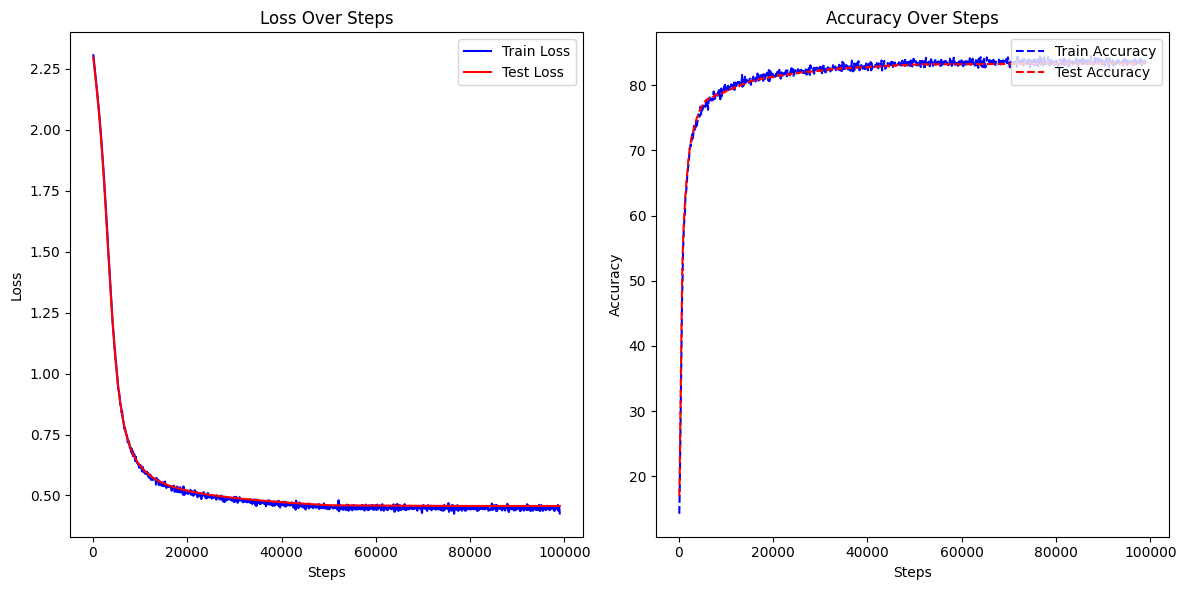

[166,   100,  99099] LR: 0.00000
[166,   100] loss: 0.44525, acc: 83.59000
[166,   100] avg_test_loss: 0.45689, avg_test_acc: 83.35
Step 99100


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

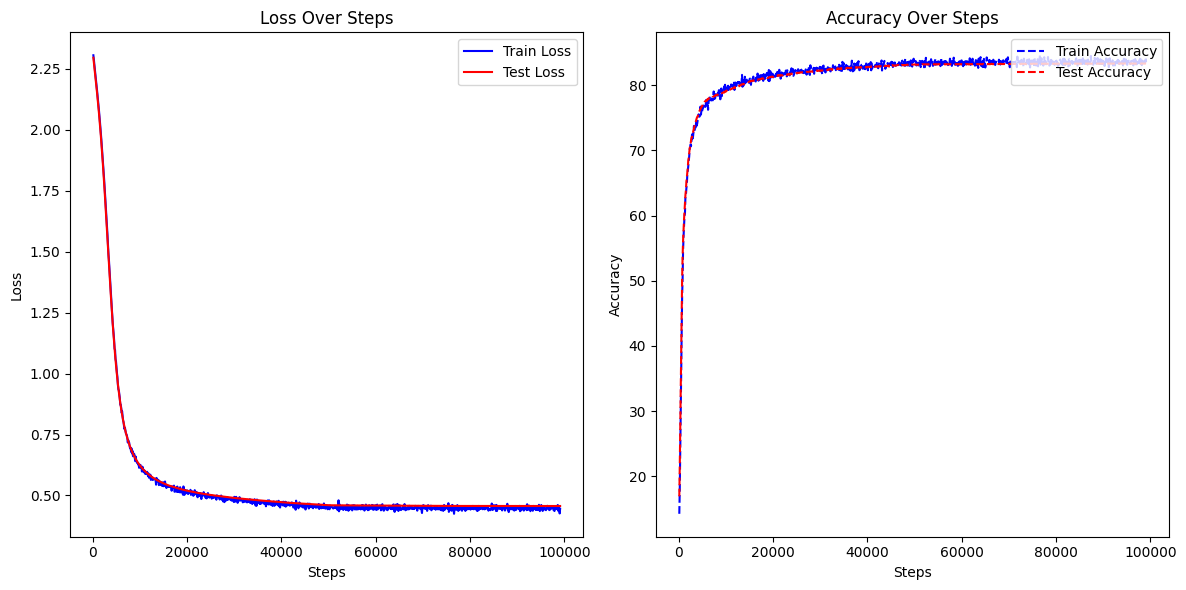

[166,   200,  99199] LR: 0.00000
[166,   200] loss: 0.44725, acc: 83.55000
[166,   200] avg_test_loss: 0.45688, avg_test_acc: 83.36
Step 99200


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

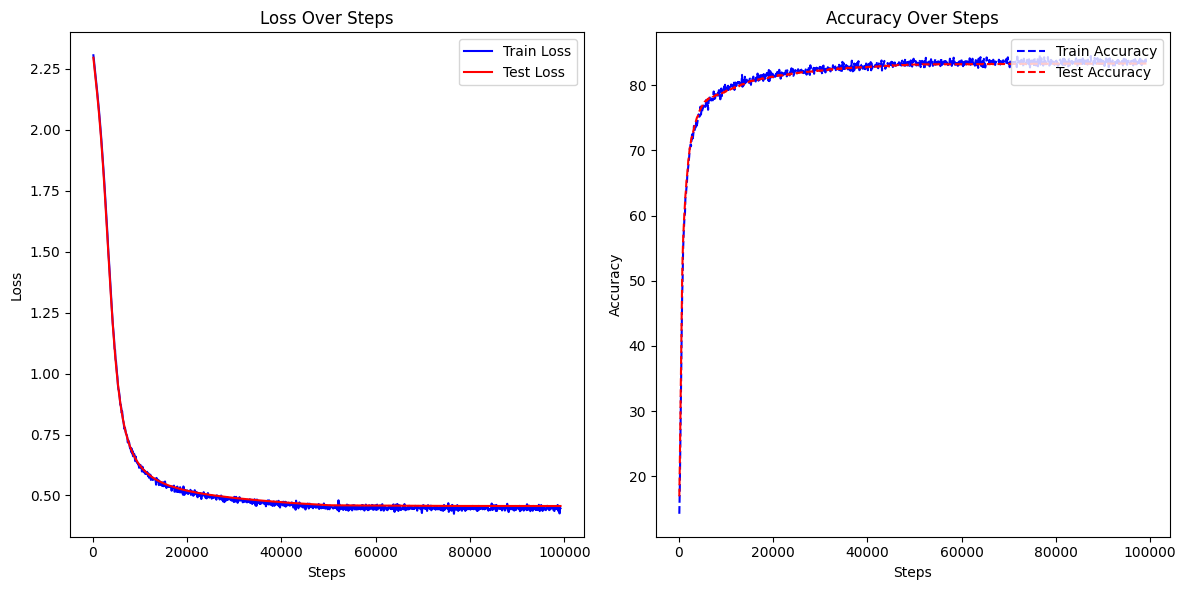

[166,   300,  99299] LR: 0.00000
[166,   300] loss: 0.44819, acc: 83.62000
[166,   300] avg_test_loss: 0.45688, avg_test_acc: 83.36
Step 99300


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

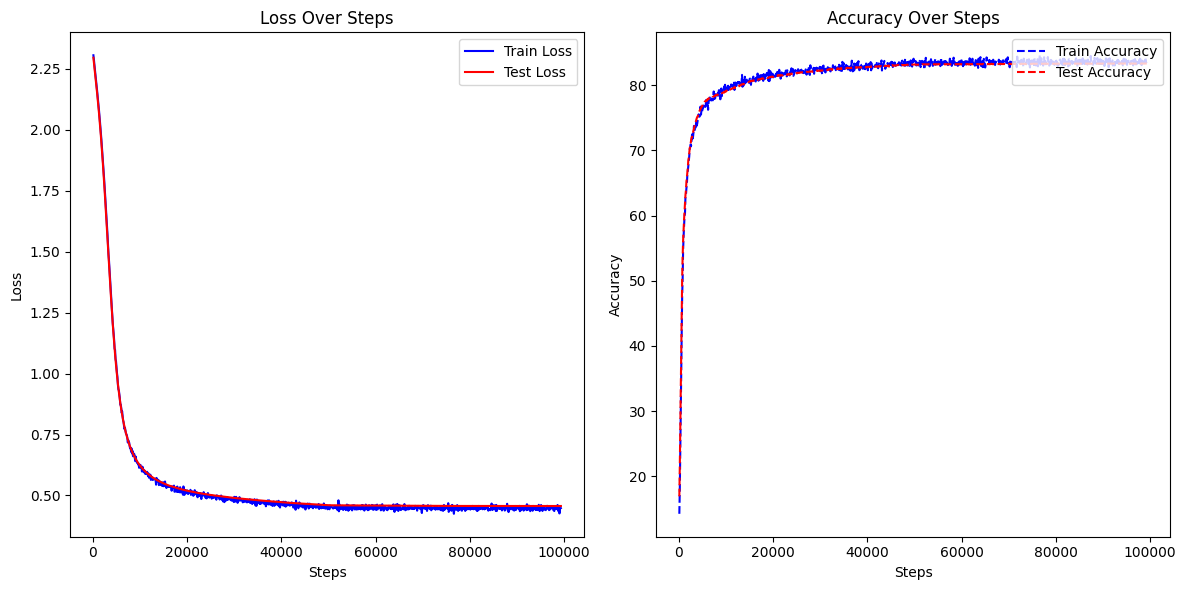

[166,   400,  99399] LR: 0.00000
[166,   400] loss: 0.44123, acc: 83.72000
[166,   400] avg_test_loss: 0.45688, avg_test_acc: 83.36
Step 99400


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

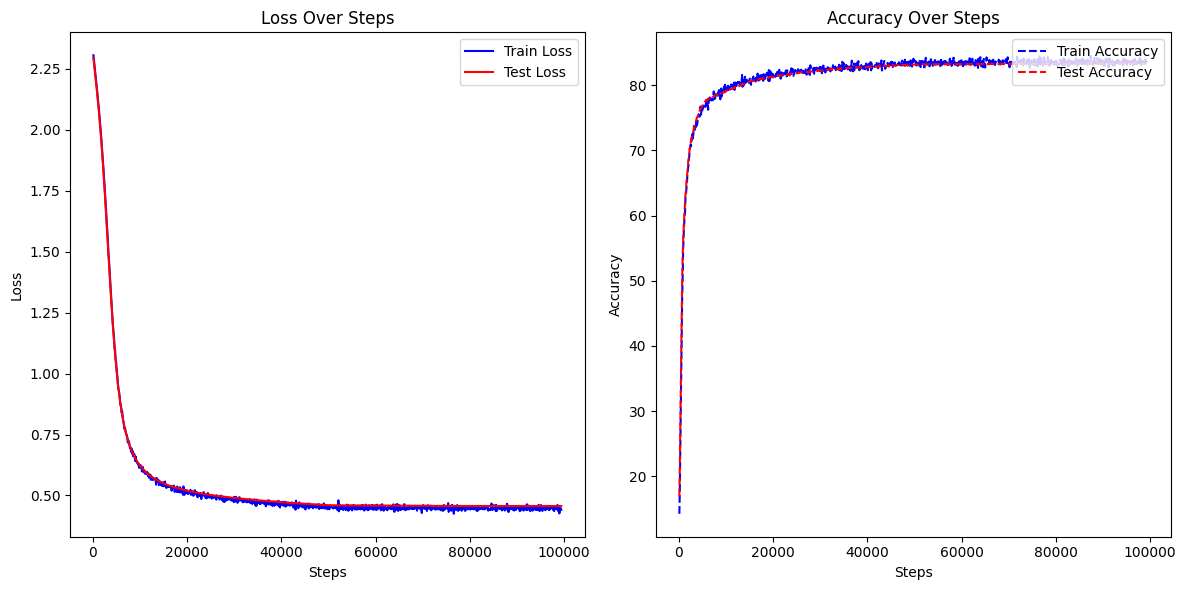

[166,   500,  99499] LR: 0.00000
[166,   500] loss: 0.45364, acc: 83.51000
[166,   500] avg_test_loss: 0.45688, avg_test_acc: 83.36
Step 99500


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

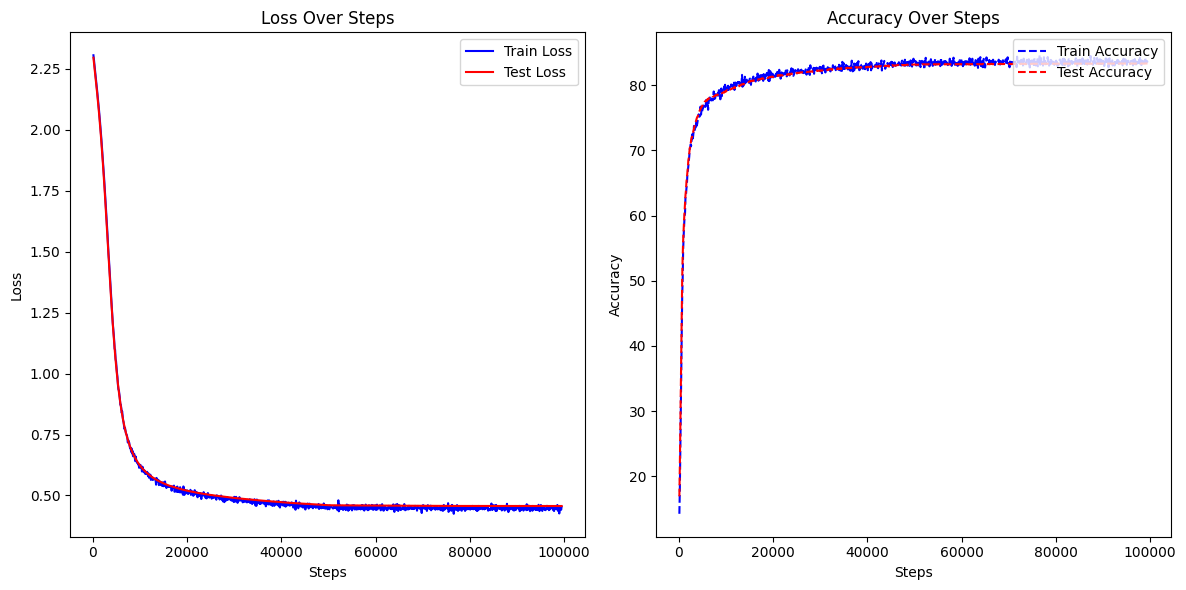

[166,   600,  99599] LR: 0.00000
[166,   600] loss: 0.45256, acc: 83.44000
[166,   600] avg_test_loss: 0.45688, avg_test_acc: 83.36
Finished Training


In [156]:
train_mlp(60000, BATCH_SIZE_TRAIN, train_loader=train_loader, test_loader=test_loader,
         net=mlp_net, lr_scheduler=lr_scheduler, optimizer=optimizer)

In [119]:
# Exemplar pentru experiment cu Fashion Dataset, Atribute, și MLP
dataset_name = "Fashion-MNIST"
input_type = "Image Attributes"
model_name = "MLP"

# Calculăm metricile pentru seturile de antrenare și test
train_precision, train_recall, train_f1, train_accuracy = evaluate_model(net, train_loader, device)
test_precision, test_recall, test_f1, test_accuracy = evaluate_model(net, test_loader, device)

# Adăugăm rezultatele în tabel
results.append({
    "Dataset": dataset_name,
    "Input Type": input_type,
    "Model": model_name,
    "Data Split": "Test",
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Accuracy": test_accuracy
})

# Conversia listei de rezultate într-un DataFrame
results_df = pd.DataFrame(results)

# Afișăm tabelul complet
results_df.style.hide()

Dataset,Input Type,Model,Data Split,Precision,Recall,F1 Score,Accuracy
Fashion-MNIST,Image Attributes,MLP,Test,0.808494,0.808000,0.807883,0.808000


### 2. Arhitectura de tip MLP direct peste imagini

#### Pregatire Date

In [161]:
# Load fashion attributes
train_images = np.load('data/fashion/X_train.npy')
y_train = np.load('data/fashion/y_train.npy')
test_images = np.load('data/fashion/X_test.npy')
y_test = np.load('data/fashion/y_test.npy')

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_images)
X_test = scaler.transform (test_images)

# Create datasets
train_images = MyDataset(train_images, y_train)
test_images = MyDataset(test_images, y_test)

# Check sizes of tensors
print(f'Size of training images {train_images.data.shape}')
print(f'Size of training labels {len(train_images.targets)}')
print(f'Size of test images {test_images.data.shape}')
print(f'Size of test labels {len(test_images.targets)}')

Size of training images torch.Size([60000, 784])
Size of training labels 60000
Size of test images torch.Size([10000, 784])
Size of test labels 10000


In [162]:
# create Dataset iterator object using the data previously downloaded
# we shuffle the data and sample repeatedly batches for training
BATCH_SIZE_TEST = 256
BATCH_SIZE_TRAIN = 256
train_loader = torch.utils.data.DataLoader(train_images, batch_size=BATCH_SIZE_TRAIN, 
                                           shuffle=SHUFFLE_DATA, 
                                           num_workers=NO_WORKERS)

# get a training batch of images and labels
(batch_train_images, batch_train_labels) = next(iter(train_loader))

# check that the shape of the training batches is the expected one
print(f'Shape of training images: {batch_train_images.size()}')
print(f'Shape of training labels: {batch_train_labels.size()}')

Shape of training images: torch.Size([256, 784])
Shape of training labels: torch.Size([256])


In [163]:
# we do the same for test dataset
test_loader = torch.utils.data.DataLoader(test_images, batch_size=BATCH_SIZE_TRAIN, 
                                          shuffle=SHUFFLE_DATA, 
                                          num_workers=NO_WORKERS)

def loopy_test_loader(dl):
    data_iter = iter(dl)
    
    while True:
        try:
            yield next(data_iter)
        except StopIteration:
            data_iter = iter(dl)
            yield next(data_iter)

(batch_test_images, batch_test_labels) = next(iter(test_loader))
print(f'Shape of test images: {batch_test_images.size()}')
print(f'Shape of test labels: {batch_test_labels.size()}')

Shape of test images: torch.Size([256, 784])
Shape of test labels: torch.Size([256])


#### Definirea Modelului

In [164]:
net = None                       # type: nn.Module
mlp_net2 = MLP(num_classes=NUM_CLASSES, in_size=(28 * 28))
    
mlp_net2.train()               # Default after init is train
mlp_net2 = mlp_net2.to(device)      # Move network to device

print(list(mlp_net2.modules())[0])

# Let us test that we can propagate a batch through the defined networks
select = 2
inputs = batch_train_images.to(device)[:select]
target = batch_train_labels[:select]

output = mlp_net2(inputs)
_, predicted = torch.max(output, 1)

print(output)
print(predicted)
print(target)


MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)
tensor([[-0.1316,  0.0013, -0.0824,  0.1356,  0.0131,  0.0725,  0.1320, -0.0060,
         -0.0932, -0.0149],
        [-0.0970,  0.0131, -0.1449,  0.1071,  0.0414,  0.1215,  0.0834, -0.0705,
         -0.0375, -0.0171]], grad_fn=<AddmmBackward0>)
tensor([3, 5])
tensor([0, 0])


#### Definire optimizatori

In [165]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define optimizer - SGD with momentum and weight_decay for L2 weight regularization
optimizer = torch.optim.SGD(mlp_net2.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
# optimizer = torch.optim.Adam(mlp_net2.parameters(), lr=lr_init)

if flag_regularize:
    optimizer = torch.optim.SGD(mlp_net2.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
    # optimizer = torch.optim.Adam(mlp_net2.parameters(), lr=lr_init, weight_decay=weight_decay_factor)
        
# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_schedule_milestones, gamma=lr_factor)

#### Antrenare si Evaluare

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

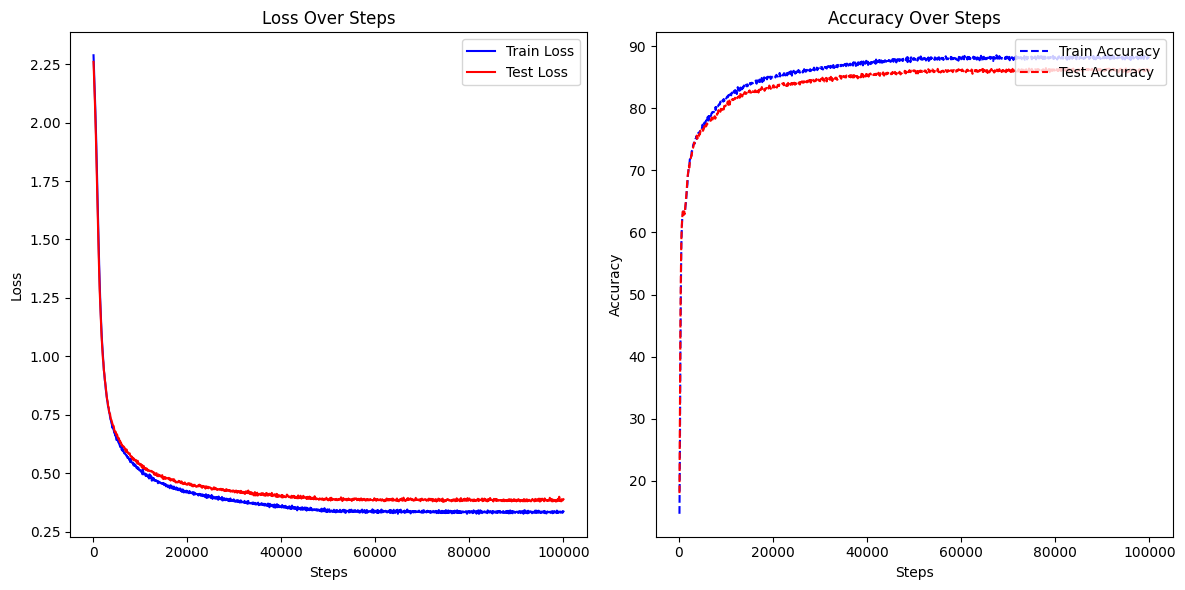

[426,   225, 100099] LR: 0.00000
[426,   225] loss: 0.32921, acc: 88.35156
[426,   225] avg_test_loss: 0.38161, avg_test_acc: 86.20
Step 100100


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

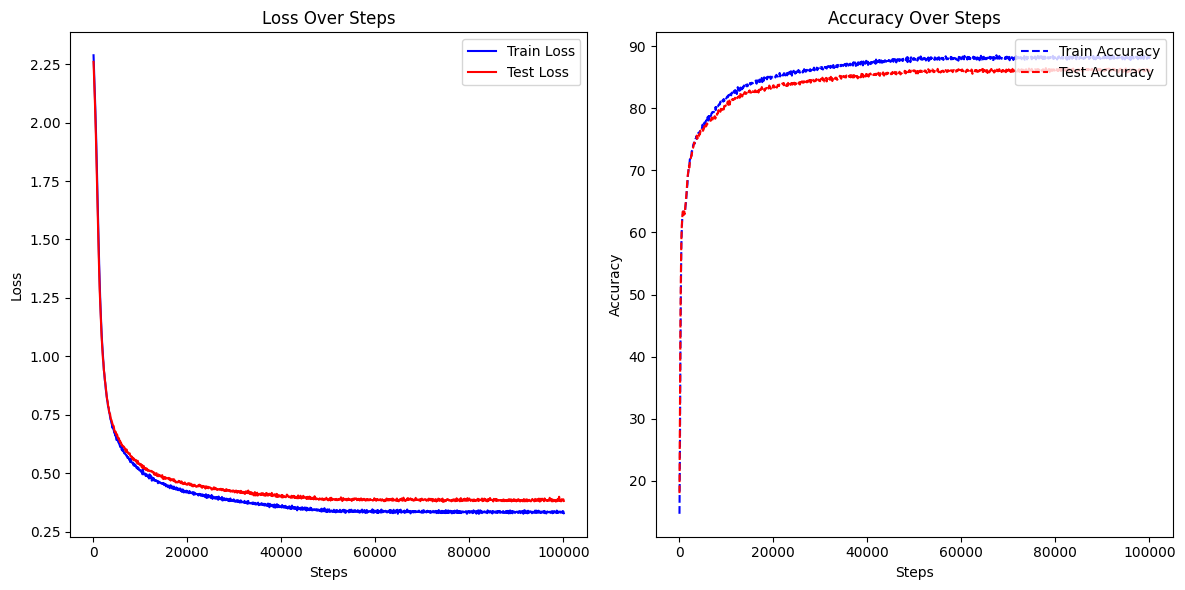

Finished Training


In [167]:
train_mlp(60000, BATCH_SIZE_TRAIN, train_loader=train_loader, test_loader=test_loader,
         net=mlp_net2, lr_scheduler=lr_scheduler, optimizer=optimizer)

In [169]:
# Exemplar pentru experiment cu Fashion Dataset, Atribute, și MLP
dataset_name = "Fashion-MNIST"
input_type = "Liniarized Images"
model_name = "MLP"

# Calculăm metricile pentru seturile de antrenare și test
train_precision, train_recall, train_f1, train_accuracy = evaluate_model(mlp_net2, train_loader, device)
test_precision, test_recall, test_f1, test_accuracy = evaluate_model(mlp_net2, test_loader, device)

# Adăugăm rezultatele în tabel
results.append({
    "Dataset": dataset_name,
    "Input Type": input_type,
    "Model": model_name,
    "Data Split": "Test",
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Accuracy": test_accuracy
})

# Conversia listei de rezultate într-un DataFrame
results_df = pd.DataFrame(results)

# Afișăm tabelul complet
results_df.style.hide()

Dataset,Input Type,Model,Data Split,Precision,Recall,F1 Score,Accuracy
Fashion-MNIST,Liniarized Images,LeNet-5,Test,0.888863,0.888100,0.888339,0.888100
Fashion-MNIST,Liniarized Images,MLP,Test,0.860365,0.861300,0.860445,0.861300


In [170]:
results_df.to_csv('results.csv', index=False)

### 3. DeepConvNet

#### Pregatire Date

In [157]:
# Load fashion attributes
train_images = np.load('data/fashion/X_train.npy')
y_train = np.load('data/fashion/y_train.npy')
test_images = np.load('data/fashion/X_test.npy')
y_test = np.load('data/fashion/y_test.npy')

# # Normalize the data
scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)

# Resize the images to 28x28
train_images = train_images.reshape(-1, 1, 28, 28)
test_images = test_images.reshape(-1, 1, 28, 28)

# Create datasets
train_images = MyDataset(train_images, y_train)
test_images = MyDataset(test_images, y_test)

# Check sizes of tensors
print(f'Size of training images {train_images.data.shape}')
print(f'Size of training labels {len(train_images.targets)}')
print(f'Size of test images {test_images.data.shape}')
print(f'Size of test labels {len(test_images.targets)}')

# Verify normalization
print(f'Min pixel value (train): {train_images.data.min()}, Max pixel value (train): {train_images.data.max()}')
print(f'Min pixel value (test): {test_images.data.min()}, Max pixel value (test): {test_images.data.max()}')

Size of training images torch.Size([60000, 1, 28, 28])
Size of training labels 60000
Size of test images torch.Size([10000, 1, 28, 28])
Size of test labels 10000
Min pixel value (train): -2.410065174102783, Max pixel value (train): 185.47760009765625
Min pixel value (test): -2.420701503753662, Max pixel value (test): 99.31272888183594


In [158]:
# create Dataset iterator object using the data previously downloaded
# we shuffle the data and sample repeatedly batches for training
BATCH_SIZE_TRAIN = 256
train_loader = torch.utils.data.DataLoader(train_images, batch_size=BATCH_SIZE_TRAIN, 
                                           shuffle=SHUFFLE_DATA, 
                                           num_workers=NO_WORKERS)

# get a training batch of images and labels
(batch_train_images, batch_train_labels) = next(iter(train_loader))

# check that the shape of the training batches is the expected one
print(f'Shape of training images: {batch_train_images.size()}')
print(f'Shape of training labels: {batch_train_labels.size()}')

Shape of training images: torch.Size([256, 1, 28, 28])
Shape of training labels: torch.Size([256])


In [159]:
# we do the same for test dataset
test_loader = torch.utils.data.DataLoader(test_images, batch_size=BATCH_SIZE_TRAIN, 
                                          shuffle=SHUFFLE_DATA, 
                                          num_workers=NO_WORKERS)

def loopy_test_loader(dl):
    data_iter = iter(dl)
    
    while True:
        try:
            yield next(data_iter)
        except StopIteration:
            data_iter = iter(dl)
            yield next(data_iter)

(batch_test_images, batch_test_labels) = next(iter(test_loader))
print(f'Shape of test images: {batch_test_images.size()}')
print(f'Shape of test labels: {batch_test_labels.size()}')

Shape of test images: torch.Size([256, 1, 28, 28])
Shape of test labels: torch.Size([256])


#### Define DeepConvNt Architecture

In [41]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.LeakyReLU(negative_slope=0.01, inplace=False),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14
            nn.Dropout2d(0.2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5
            nn.Dropout2d(0.2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.LeakyReLU(negative_slope=0.01, inplace=False),
            nn.Linear(in_features=120, out_features=10)
        )
        
    def forward(self, x):
        return self.classifier(self.feature(x))

In [75]:
# model
net = None                       # type: nn.Module
net = LeNet()
    
net.train()               # Default after init is train
net = net.to(device)      # Move network to device

print(list(net.modules())[0])

# Let us test that we can propagate a batch through the defined networks
select = 2
inputs = batch_train_images.to(device)[:select]
target = batch_train_labels[:select]

output = net(inputs)
_, predicted = torch.max(output, 1)

print(output)
print(predicted)
print(target)

LeNet(
  (feature): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Dropout2d(p=0.2, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=120, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=120, out_features=10, bias=True)
  )
)
tensor([[ 0.0142,  0.0174,  0.0549,  0.0772,  0.0298, -0.0039, -0.0086,  0.0781,
         -0.0861, -0.0359],
        [ 0.0158,  0.0102,  0.0622,  0.0743,  0.0316, -0.0010, -0.0024,  0.0697,
         -0.0829, -0.0345]], grad_fn=<AddmmBackward0>)
tensor([7, 3])
tensor([7, 8])


In [76]:
lr_init = 0.001             # initial learning rate
lr_factor = 0.1             # learning rate decay factor
weight_decay_factor = 1e-4  # weight decay factor for L2 weight regularization
lr_schedule_milestones = [50e3, 75e3, 100e3]

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define optimizer - SGD with momentum and weight_decay for L2 weight regularization
optimizer = torch.optim.Adam(net.parameters(), lr=lr_init)

if flag_regularize:
    optimizer = torch.optim.Adam(net.parameters(), lr=lr_init, weight_decay=weight_decay_factor)
        
# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_schedule_milestones, gamma=lr_factor)

#### Train and Evaluate Model

In [81]:
def train_lenet(train_dataset_size, batch_size_train, train_loader, test_loader, net, lr_scheduler, optimizer):
    epochs = int(TRAIN_ITERS / (train_dataset_size / batch_size_train))

    train_iter = 0
    train_losses = []
    train_accuracy = []
    test_losses = []
    test_accuracy = []
    steps = []

    # simulate an inifinte test data provider by looping over the test data
    test_data_provider = loopy_test_loader(test_loader)

    # set model in train mode
    net.train()

    running_loss = 0.0
    running_acc = 0.0
    ct = 0

    for epoch in range(int(epochs)):  # loop over the dataset multiple times
        
        for i, data in enumerate(train_loader, 0):
            # set the learning rate and decay according to iteration schedule
            lr_scheduler.step()
            
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            running_acc += top_k_accuracy(1, labels, outputs)
            
            if train_iter % REPORT_TRAIN_EVERY == REPORT_TRAIN_EVERY - 1:    # print every REPORT_TRAIN_EVERY mini-batch iterations
                train_loss = running_loss / REPORT_TRAIN_EVERY
                train_acc = running_acc / REPORT_TRAIN_EVERY
                
                print('[%d, %5d, %6d] LR: %.5f' % (epoch + 1, i + 1, train_iter, lr_scheduler.get_lr()[-1]))
                print('[%d, %5d] loss: %.5f, acc: %.5f' %
                    (epoch + 1, i + 1, train_loss, train_acc))
                
                train_losses.append(train_loss)
                train_accuracy.append(train_acc.item())
                steps.append(train_iter)
                
                running_loss = 0
                train_loss = 0
                train_acc = 0
                running_acc = 0
                
            if train_iter % PLOT_EVERY == 0:
                # plot_losses(losses, acc, steps, train_iter)
                plot_loss_and_accuracy_side_by_side(train_losses, test_losses, train_accuracy, test_accuracy, steps, train_iter)
                
            train_iter += 1
        
            if train_iter % REPORT_TEST_EVERY == 0:
                # set model in test mode
                net.eval()
                
                with torch.no_grad():
                    # evaluate over at most TEST_ITER sub samples from the test_loader
                    test_iter = 0
                    test_loss = 0
                    correct = 0
                    
                    while test_iter < TEST_ITERS:
                    # for j, test_data in enumerate(test_loader, start=test_ct):
                        test_data = next(test_data_provider)
                            
                        # get the test inputs; data is a list of [inputs, labels]
                        test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)
                        
                        out = net(test_inputs)
                        test_loss += criterion(out, test_labels)
                        
                        
                        correct += top_k_accuracy(1, test_labels, out)
                        
                        test_iter += 1
                        
                    avg_test_loss = test_loss / TEST_ITERS
                    avg_acc = correct / TEST_ITERS

                    test_losses.append(avg_test_loss.item())
                    test_accuracy.append(avg_acc.item())
                    
                    print('[%d, %5d] avg_test_loss: %.5f, avg_test_acc: %.2f' 
                        % (epoch + 1, i + 1, avg_test_loss, avg_acc))
                    
                # set model back in train mode
                net.train()

    print('Finished Training')

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

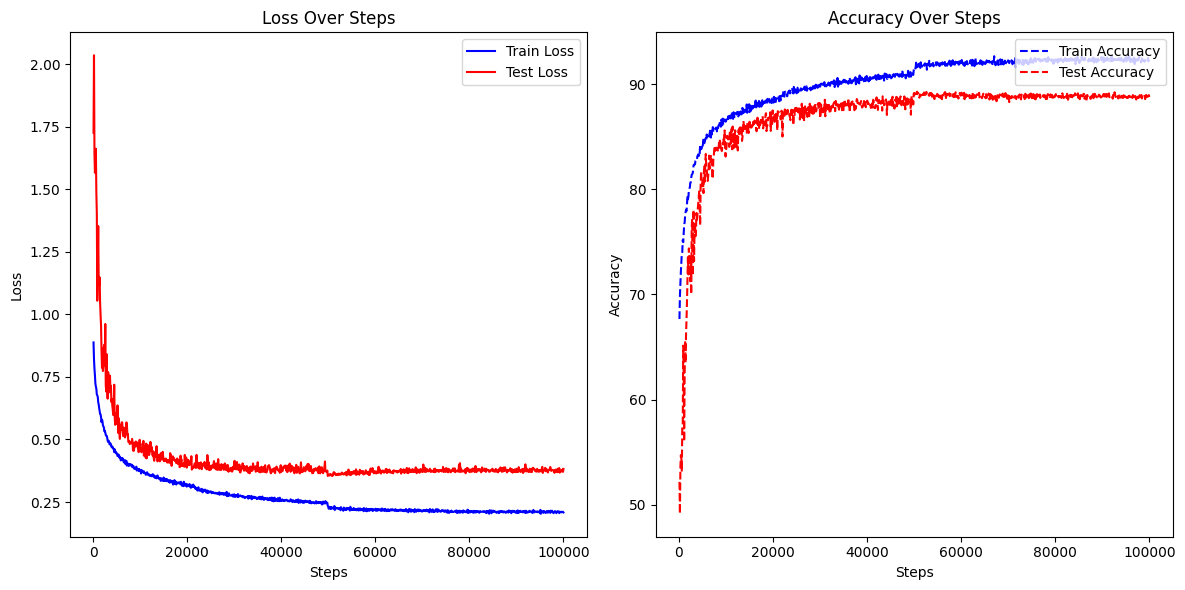

[426,   225, 100099] LR: 0.00000
[426,   225] loss: 0.21239, acc: 92.37500
[426,   225] avg_test_loss: 0.37364, avg_test_acc: 88.84
Step 100100


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

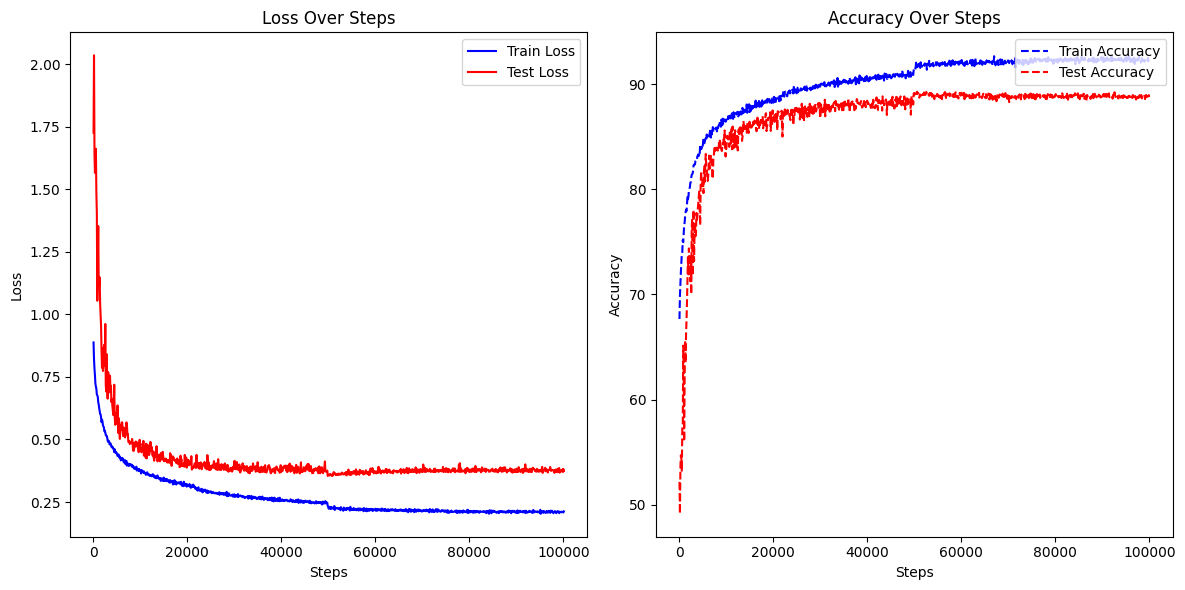

Finished Training


In [84]:
train_lenet(60000, 256, train_loader=train_loader, test_loader=test_loader,
         net=net, lr_scheduler=lr_scheduler, optimizer=optimizer)

#### Evaluate

In [85]:
# Exemplar pentru experiment cu Fashion Dataset, Atribute, și MLP
dataset_name = "Fashion-MNIST"
input_type = "Liniarized Images"
model_name = "LeNet-5"

# Calculăm metricile pentru seturile de antrenare și test
train_precision, train_recall, train_f1, train_accuracy = evaluate_model(net, train_loader, device)
test_precision, test_recall, test_f1, test_accuracy = evaluate_model(net, test_loader, device)

# Adăugăm rezultatele în tabel
results.append({
    "Dataset": dataset_name,
    "Input Type": input_type,
    "Model": model_name,
    "Data Split": "Test",
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Accuracy": test_accuracy
})

# Conversia listei de rezultate într-un DataFrame
results_df = pd.DataFrame(results)

# Afișăm tabelul complet
results_df.style.hide()

Dataset,Input Type,Model,Data Split,Precision,Recall,F1 Score,Accuracy
Fashion-MNIST,Liniarized Images,LeNet-5,Test,0.888863,0.888100,0.888339,0.888100


In [86]:
# saving the dataframe
results_df.to_csv('LeNet-5.csv')

### 4. Finetuning pe Modele Preantrenate

## Fruits-360